<div style="font-weight:bold;font-size:30px;margin-bottom:-5px">Term Paper Challange: Finvia Leads Prediction</div>

*submitted by: Lixiao Hu, Moritz Raykowski and Robin Reiners*

---

An important starting point for marketing is the generation of leads.1 Leads can lead to sales pitches and,ultimately, to sales. In this challenge, we try to forecast NextDayLeads from past data. Leads are affected by advertising campaigns and marketing spending, and many other factors including seasonal effects and macroeconomic trends. Proper forecasting of the number of leads helps to plan resources in the marketing and sales departments

<p style="font-weight: bold">Table of Content:</p>

* [1: Import Data](#import-data)
* [2: Exploratory Analysis & Data Preparation](#exploratory-analysis)
* [3: Feature Engineering](#feature-engineering)
* [4: Hyper-Parameter Tuning](#hyper-parameter-tuning)
* [5: Evaluation](#evaluation)
* [6: Final Predictions for April](#final-predictions)

---

*install required dependencies:*

In [204]:
import importlib

def import_or_install(package):
    try:
        importlib.import_module(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing...")
        import subprocess
        subprocess.check_call(['pip', 'install', package])
        print(f"{package} has been installed.")


libraries = ['numpy', 'pandas', 'matplotlib', 'seaborn', 'tensorflow', 'sklearn', 'keras', 'pydot', 'openpyxl', 'statsmodels', 'xgboost', 'category_encoders']

for library in libraries:
    import_or_install(library)
    globals()[library] = importlib.import_module(library)


import copy
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from matplotlib.ticker import PercentFormatter

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Display the plot centered within the cell
display(HTML("<style>.output { display: flex; justify-content: center; }</style>"))
# Show all columns
pd.set_option('display.max_columns', None)
# Disable the SettingWithCopyWarning
pd.options.mode.chained_assignment = None

numpy is already installed.
pandas is already installed.
matplotlib is already installed.
seaborn is already installed.
tensorflow is already installed.
sklearn is already installed.
keras is already installed.
pydot is already installed.
openpyxl is already installed.
statsmodels is already installed.
xgboost is already installed.
category_encoders is already installed.


<a id='import-data'></a> <p style="text-decoration: underline; font-style: italic; font-size:24px">Import Data</p>

In [205]:
path_to_input_file = 'data/termpaperchallenge.xlsx'

In [206]:
sheets = ['Leads', 'Ads', 'WebsiteTraffic', 'Macro']
date_columns = ['DateCreated', 'Date', 'Date', 'Date']

dataframes = {sheet: pd.read_excel(path_to_input_file, sheet_name=sheet) for sheet in sheets}
cutoff_date = '2023-04-01'
filtered_dataframes = {sheet: df[df[date_col] < cutoff_date] for sheet, df, date_col in zip(sheets, dataframes.values(), date_columns)}

# Now you can access each filtered dataframe using its corresponding variable name
dt_Leads = filtered_dataframes['Leads']
dt_Ads = filtered_dataframes['Ads']
dt_Traffic = filtered_dataframes['WebsiteTraffic']
dt_Macro = filtered_dataframes['Macro']

In [207]:
# Shift and fill with 0 for the first row
dt_Leads['Leads'] = dt_Leads['NextDayLeads'].shift(fill_value=0)
# Drop the original NextDayLeads column
dt_Leads.rename(columns={'DateCreated': 'Date'}, inplace=True)

<a id='exploratory-analysis'></a> <p style="text-decoration: underline; font-style: italic; font-size:24px">Exploratory Analysis & Data Preparation</p>

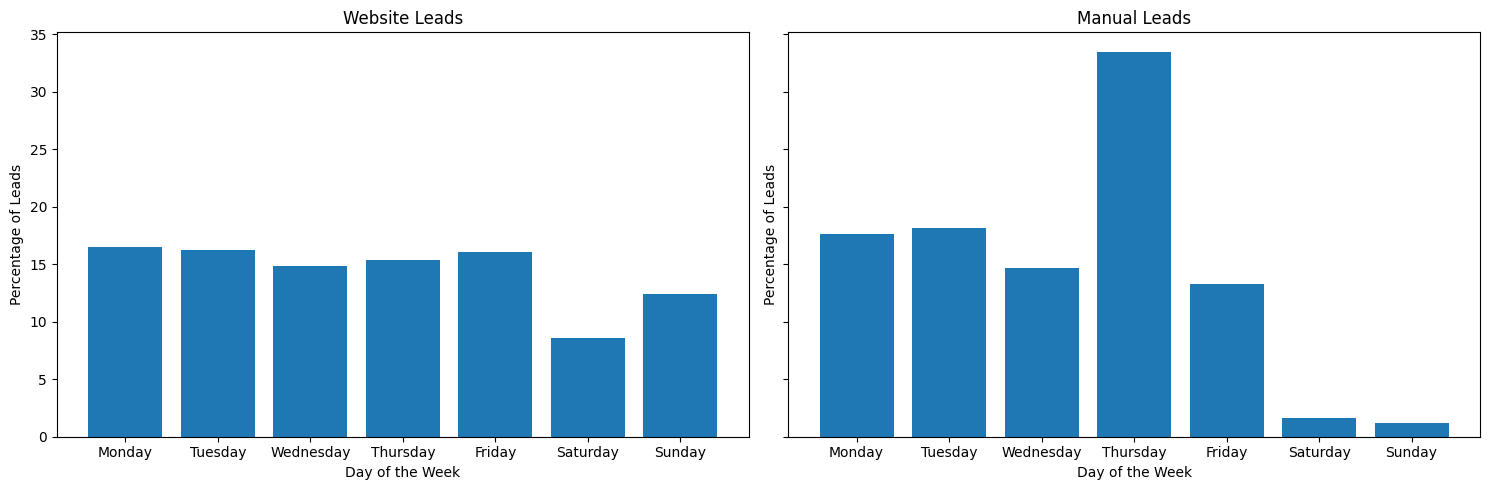

In [208]:
def check_weekend_days_subplot(ax, df, title): 
    # Convert to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Create a new column for day of the week
    df['DayOfWeek'] = df['Date'].dt.dayofweek

    # Group the data by day of the week and calculate the percentage of leads for each day
    leads_per_weekday = df.groupby('DayOfWeek')['Leads'].sum()
    total_leads = leads_per_weekday.sum()
    leads_percentage = (leads_per_weekday / total_leads) * 100

    # Define the days of the week labels
    weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Create a bar plot in the given subplot
    ax.bar(weekday_labels, leads_percentage)
    ax.set_xlabel('Day of the Week')
    ax.set_ylabel('Percentage of Leads')
    ax.set_title(title)

# Assuming dt_Leads is your dataframe
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)  # Create a 1x2 grid of subplots

# Call the function for Website leads subplot
check_weekend_days_subplot(axes[0], dt_Leads[dt_Leads['Type'] == 'Website'], 'Website Leads')

# Call the function for Manual leads subplot
check_weekend_days_subplot(axes[1], dt_Leads[dt_Leads['Type'] == 'Manual'], 'Manual Leads')

# Adjust layout
plt.tight_layout()
plt.show()

Our assumption was that there are no manual leads on Saturday and Sunday - therefore we wanted to kick them out as we don't have Macrodata for week end days -> but apparently there are datapoint's therefore we keep them in

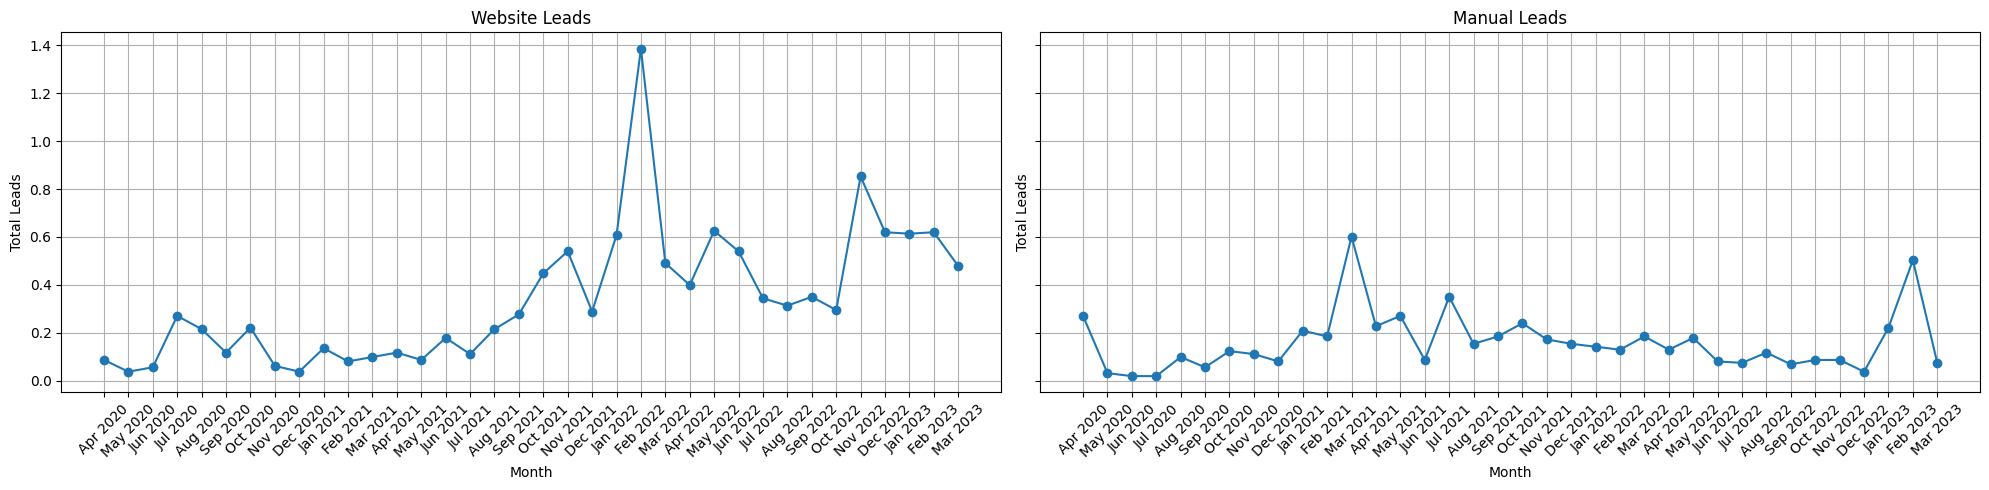

In [209]:
def check_month_trend(ax, df, title):
    # Group the data by month and calculate the total leads for each month
    monthly_leads = df.groupby(df['Date'].dt.to_period('M'))['Leads'].sum()

    # Convert the Period index to string format
    monthly_leads.index = monthly_leads.index.to_timestamp('D').strftime('%b %Y')

    # Plot the leads trend over the months
    ax.plot(monthly_leads.index, monthly_leads.values, marker='o')
    ax.set_xlabel('Month')
    ax.set_ylabel('Total Leads')
    ax.set_title(title)
    ax.set_xticks(monthly_leads.index)
    ax.set_xticklabels(monthly_leads.index, rotation=45)
    ax.grid(True)

# Assuming dt_Leads is your dataframe
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)  # Create a 1x2 grid of subplots

# Call the function for Website leads subplot
check_month_trend(axes[0], dt_Leads[dt_Leads['Type'] == 'Website'], 'Website Leads')

# Call the function for Manual leads subplot
check_month_trend(axes[1], dt_Leads[dt_Leads['Type'] == 'Manual'], 'Manual Leads')

# Adjust layout
plt.tight_layout()
plt.show()

In [210]:
manual_leads = dt_Leads[dt_Leads['Type'] == 'Manual'].copy()
manual_leads = manual_leads.merge(dt_Macro, how='left', on='Date')

We assusme that Funnel does not hold a lot of predictive power for the target variable and would make the matrix too sparse therefore we aggregate the data by Date, Platform and measure the sum of the Clicks, Impressions and Spend. We can see, that only Clicks_Google Ads, Clicks_LinkedIn Ads, Impressions_Google Ads, Impressions_LinkedIn Ads, Spend_Google Ads, Spend_LinkedIn Ads holds enough information, therefore we drop the rest

In [211]:
# Pivot the dataframe to have one date per row and one-hot encoding for Platform and Funnel
pivot_Ads = dt_Ads.pivot_table(index='Date', columns=['Platform'], values=['Spend', 'Impressions', 'Clicks'], aggfunc='sum')
# Flatten the multi-level column index
pivot_Ads.columns = ['_'.join(col).strip() for col in pivot_Ads.columns.values]

# Reset index to make 'Date' a regular column
pivot_Ads = pivot_Ads.reset_index().set_index('Date')

pivot_Ads.describe()

,Clicks_Facebook Ads,Clicks_Google Ads,Clicks_Google D&V 360,Clicks_LinkedIn Ads,Clicks_Outbrain,Impressions_Facebook Ads,Impressions_Google Ads,Impressions_Google D&V 360,Impressions_LinkedIn Ads,Impressions_Outbrain,Spend_Facebook Ads,Spend_Google Ads,Spend_Google D&V 360,Spend_LinkedIn Ads,Spend_Outbrain
count,46.000000,628.000000,272.000000,614.000000,140.000000,46.000000,628.000000,272.000000,614.000000,140.000000,46.000000,628.000000,272.000000,614.000000,140.000000
mean,0.000841,0.152921,0.304631,0.010463,0.223735,0.000216,0.017415,0.136362,0.004784,0.327395,0.002372,0.473837,0.141090,0.093585,0.115203
std,0.002684,0.138323,0.166605,0.012143,0.235498,0.000601,0.030163,0.068046,0.008337,0.309456,0.004684,0.357719,0.068151,0.124108,0.106197
min,0.000000,0.000605,0.000000,0.000000,0.000000,0.000008,0.000056,0.000000,0.000000,0.000000,0.000117,0.000234,0.000000,0.000000,0.000000
25%,0.000000,0.051391,0.191052,0.004232,0.038543,0.000018,0.003119,0.090521,0.001235,0.057432,0.000270,0.147907,0.108672,0.031115,0.022091
50%,0.000000,0.130290,0.288694,0.006651,0.129686,0.000036,0.008871,0.129714,0.002079,0.224762,0.000575,0.434010,0.139930,0.064825,0.091279
75%,0.000605,0.200272,0.433343,0.012092,0.381046,0.000095,0.015962,0.185134,0.004025,0.535001,0.001224,0.711409,0.174705,0.105854,0.205088
max,0.016929,0.999395,0.752116,0.125756,1.000000,0.003768,0.178877,0.426672,0.092344,1.251995,0.020547,1.538880,0.395662,1.198756,0.365798


In [212]:
dt_Ads = pd.concat([pivot_Ads.filter(like='Google Ads', axis=1), pivot_Ads.filter(like='LinkedIn Ads', axis=1)], axis=1)

website_leads = dt_Leads[dt_Leads['Type'] == 'Website'].copy()
website_leads = website_leads.merge(dt_Ads, how='left', on='Date')
website_leads = website_leads.merge(dt_Traffic, how='left', on='Date')
website_leads = website_leads.merge(dt_Macro, how='left', on='Date')

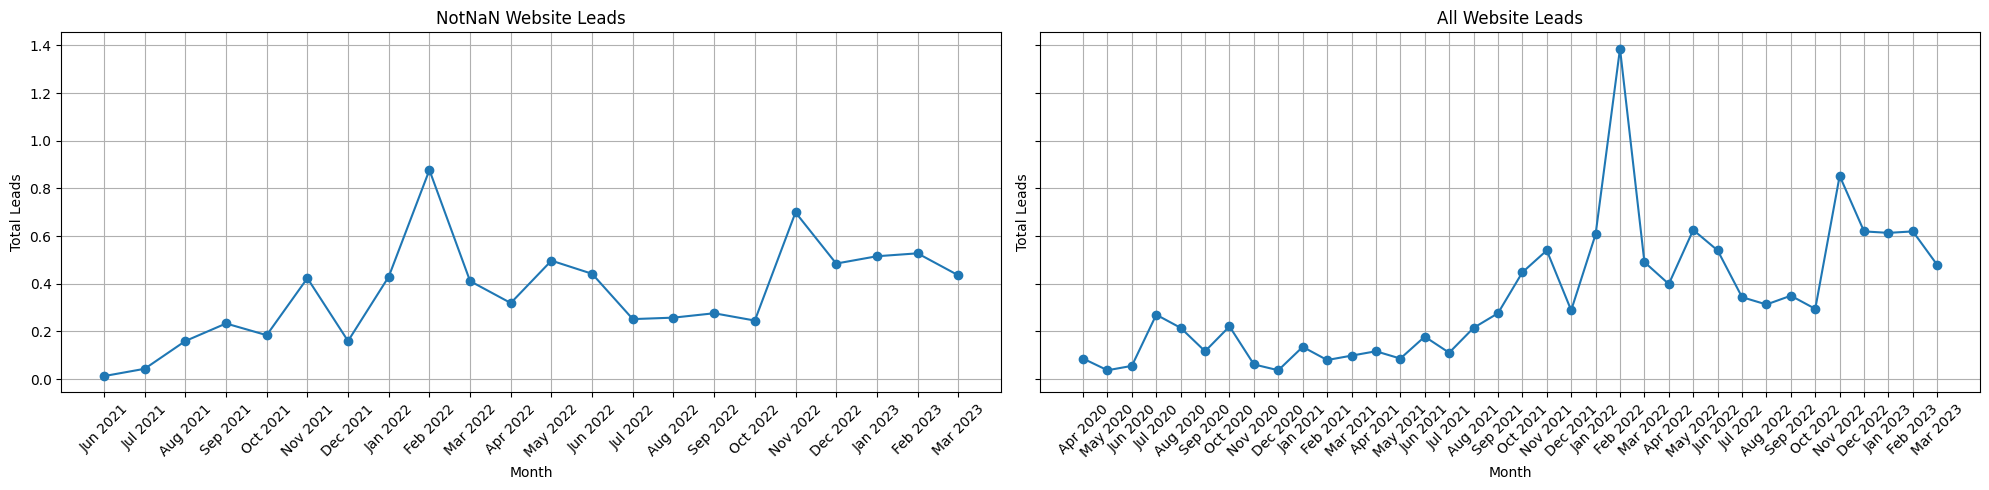

In [213]:
# Assuming dt_Leads is your dataframe
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)  # Create a 1x2 grid of subplots

# Call the function for Website leads subplot
check_month_trend(axes[0], website_leads.dropna(how='any'), 'NotNaN Website Leads')

# Call the function for Manual leads subplot
check_month_trend(axes[1], dt_Leads[dt_Leads['Type'] == 'Website'], 'All Website Leads')

# Adjust layout
plt.tight_layout()
plt.show()

We can see that information about Ads is only available after Jun 2021 - but because we can see a structural shift after that we decide to not train on older data as we believe it does not generalize into the future.

In [214]:
website_leads = website_leads.query(f"Date >= '{dt_Ads.index.min()}'")

In [215]:
# we only have macro data for weekdays
dt_Macro['Date'].dt.dayofweek.unique()

array([2, 3, 4, 0, 1])

In [216]:
# therefore we use a forwardfill to fill the missing values
website_leads[dt_Macro.loc[:, dt_Macro.columns != 'Date'].columns] = website_leads[dt_Macro.loc[:, dt_Macro.columns != 'Date'].columns].fillna(method='ffill')

In [217]:
# now we only have some missing values from Ads which we fill with 0
website_leads.fillna(0, inplace=True)

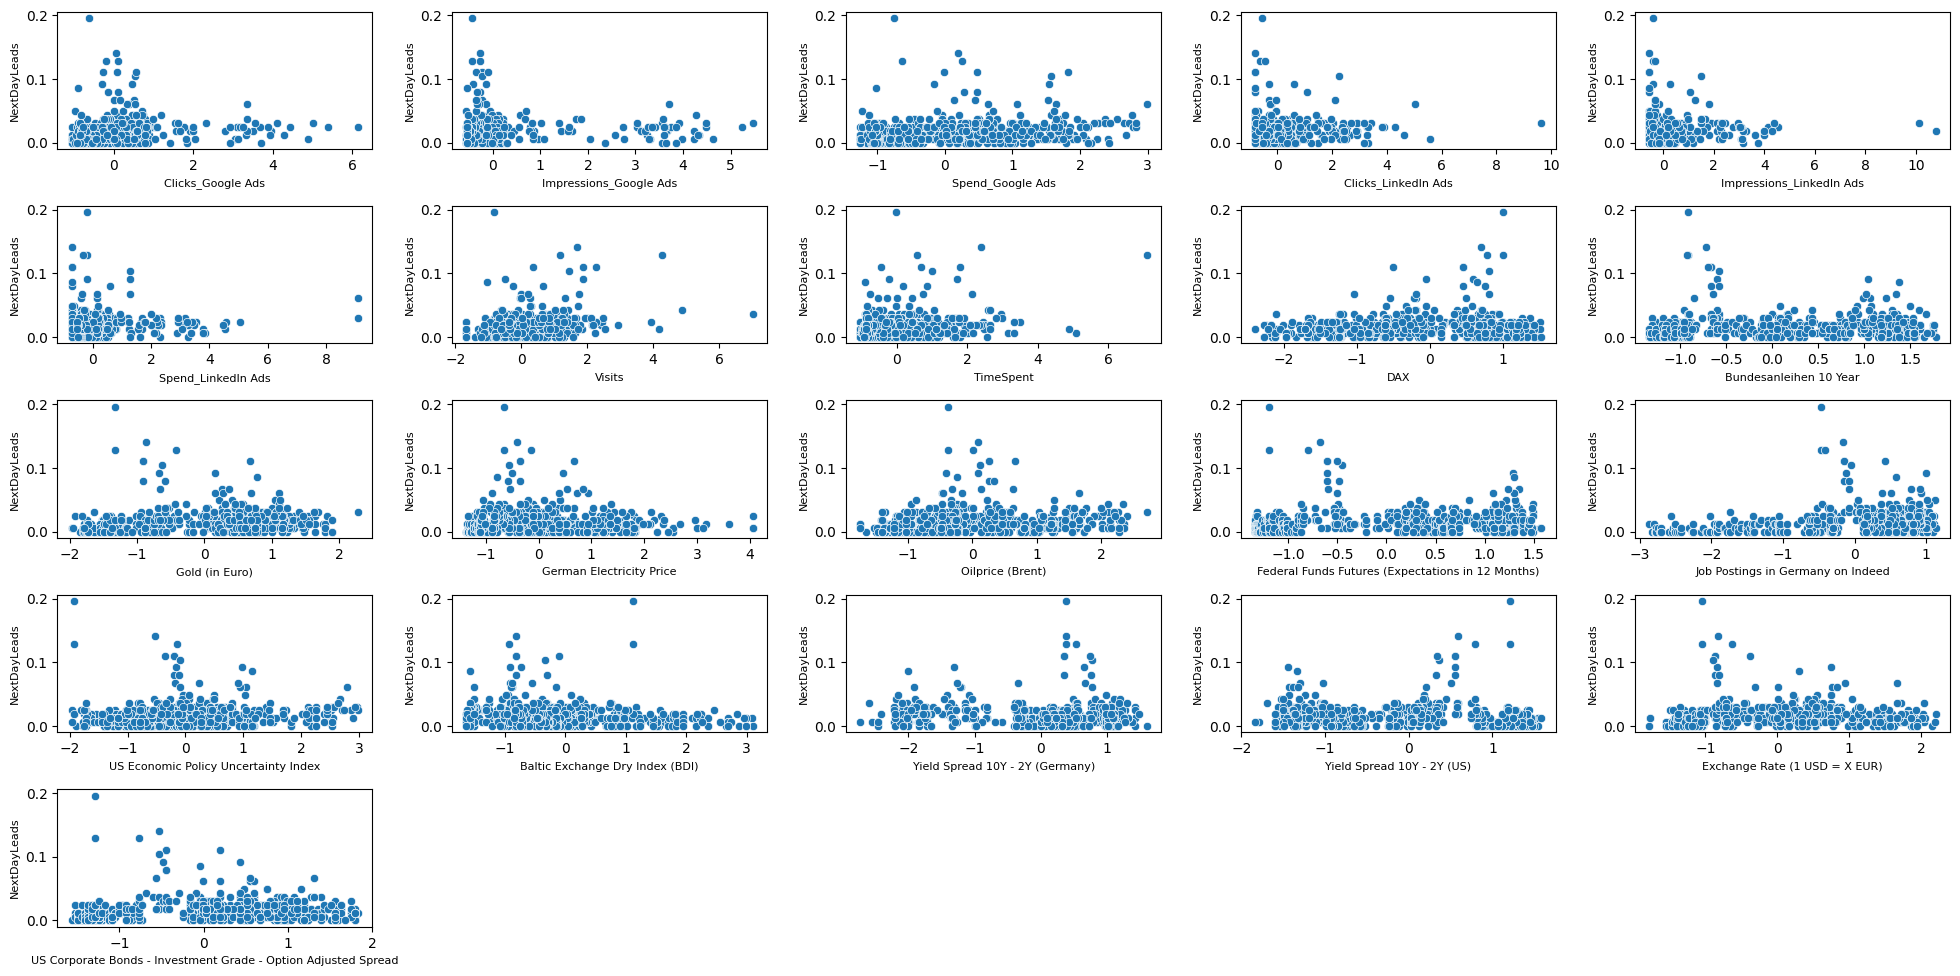

In [218]:
from sklearn.preprocessing import StandardScaler

# Drop columns to get only the independent variables
independent_vars = website_leads.drop(columns=['NextDayLeads', 'Leads', 'Type', 'Date'])

# Normalize the independent variables
scaler = StandardScaler()
normalized_independent_vars = scaler.fit_transform(independent_vars)

# Calculate the number of rows and columns for the subplots
num_rows = 5
num_cols = 5

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
fig.tight_layout(pad=2)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Scatter plot each normalized independent variable against the dependent variable
for i, column in enumerate(independent_vars.columns):
    sns.scatterplot(x=normalized_independent_vars[:, i], y=website_leads['NextDayLeads'], ax=axes[i])
    axes[i].set_xlabel(column, fontsize=8)
    axes[i].set_ylabel('NextDayLeads', fontsize=8)

# Hide any remaining empty subplots
for j in range(len(independent_vars.columns), num_rows * num_cols):
    axes[j].axis('off')

plt.show()

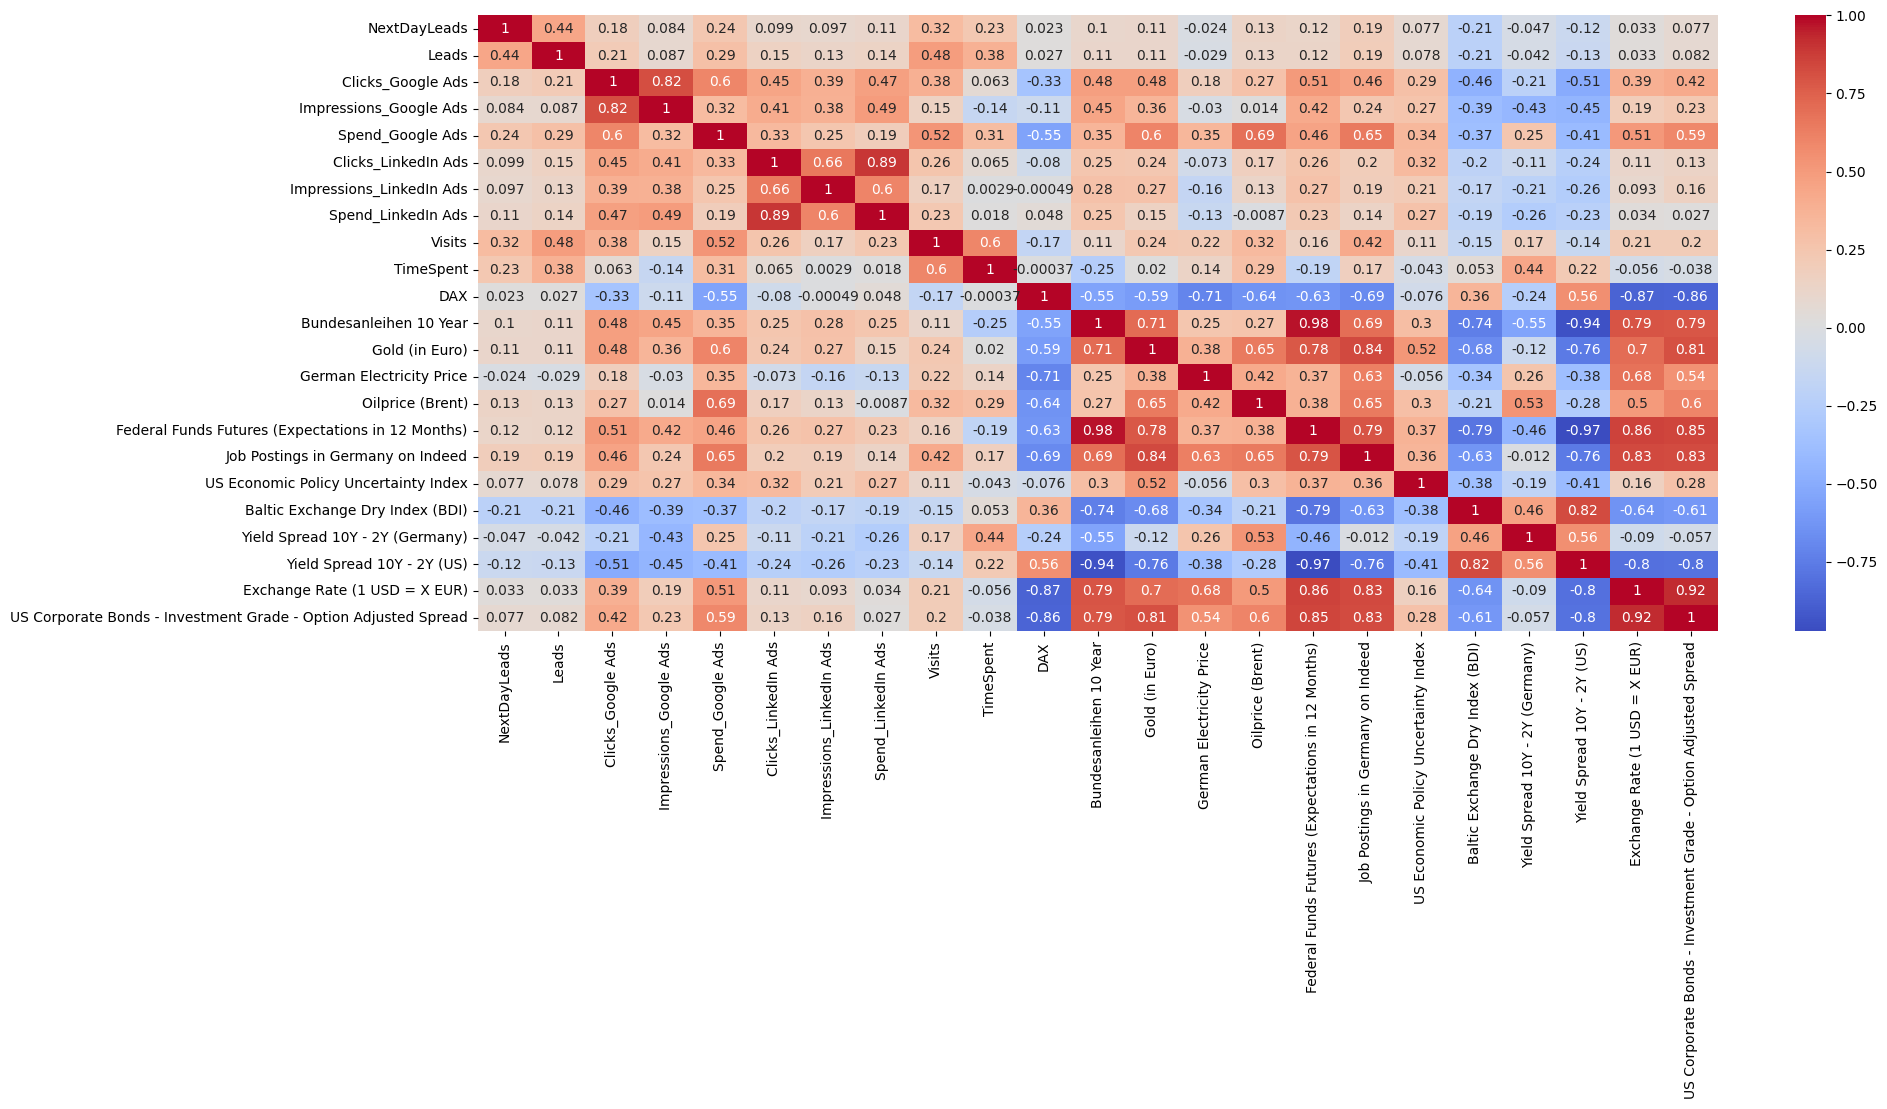

In [219]:
# Correlation Heatmap
correlation_matrix = website_leads.drop(columns=['Type', 'Date']).corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

We can see, that the features do not really correlate with NextDayLeads !! But Ensemble Decision Tree algorithms, such as Random Forests, don't necessarily rely on strong correlations between features and the dependent variable. Instead, they utilize an ensemble approach by combining predictions from multiple decision trees to enhance prediction accuracy. This capability enables them to effectively manage a mixture of features with varying degrees of correlation to the target variable. 

Due to time constraintes we don't consider a reverse feature elimination approach but consider all variables available

In [220]:
# because Macro Data is the only data available for manual leads, we also ffill (and for the first weekeende we bfill)
manual_leads[dt_Macro.loc[:, dt_Macro.columns != 'Date'].columns] = manual_leads[dt_Macro.loc[:, dt_Macro.columns != 'Date'].columns].fillna(method='ffill')
manual_leads = manual_leads.fillna(method='bfill')

<a id='feature-engineering'></a> <p style="text-decoration: underline; font-style: italic; font-size:24px">Feature Engineering</p>

A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation.

We can do that using the following transformations:

$$x_{\text{sin}} = \sin(2 \pi x_{\text{max}}(x))
$$
$$x_{\text{cos}} = \cos(2 \pi x_{\text{max}}(x))$$

In [221]:
def cyclical_encode(dataframe, feature_name, period):
    dataframe[feature_name + '_sin'] = np.sin(2 * np.pi * dataframe[feature_name] / period)
    dataframe[feature_name + '_cos'] = np.cos(2 * np.pi * dataframe[feature_name] / period)
    dataframe.drop(columns=[feature_name], inplace=True)
    
def generate_time_series_features(dataframe, lags):
    df = dataframe.copy()
    for lag in lags:
        df[f'Lag_{lag}'] = df['NextDayLeads'].shift(lag)
    
    df['DayOfWeek'] = df.Date.dt.dayofweek
    df['Month'] = df.Date.dt.month
    
    cyclical_encode(df, 'DayOfWeek', 7)  # 7 days in a week
    cyclical_encode(df, 'Month', 12)     # 12 months in a year
        
    return df.fillna(method='bfill')

In [222]:
# example of time series features
generate_time_series_features(manual_leads, range(1,3)).head()

,Date,Type,NextDayLeads,Leads,DAX,Bundesanleihen 10 Year,Gold (in Euro),German Electricity Price,Oilprice (Brent),Federal Funds Futures (Expectations in 12 Months),Job Postings in Germany on Indeed,US Economic Policy Uncertainty Index,Baltic Exchange Dry Index (BDI),Yield Spread 10Y - 2Y (Germany),Yield Spread 10Y - 2Y (US),Exchange Rate (1 USD = X EUR),US Corporate Bonds - Investment Grade - Option Adjusted Spread,Lag_1,Lag_2,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos
0,2020-04-04,Manual,0.006135,0.000000,10075.17,-0.420,1529.27,21.19,33.27,0.095,88.00,471.941,604.0,0.218,0.414,0.927343,2.7418,0.006135,0.006135,-0.974928,-0.222521,0.866025,-0.5
1,2020-04-05,Manual,0.006135,0.006135,10075.17,-0.420,1529.27,21.19,33.27,0.095,88.00,471.941,604.0,0.218,0.414,0.927343,2.7418,0.006135,0.006135,-0.781831,0.623490,0.866025,-0.5
2,2020-04-06,Manual,0.018405,0.006135,10075.17,-0.420,1529.27,21.19,33.27,0.095,88.00,471.941,604.0,0.218,0.414,0.927343,2.7418,0.006135,0.006135,0.000000,1.000000,0.866025,-0.5
3,2020-04-07,Manual,0.000000,0.018405,10356.70,-0.314,1517.23,23.21,31.95,0.105,87.48,480.539,596.0,0.293,0.454,0.918949,2.6259,0.018405,0.006135,0.781831,0.623490,0.866025,-0.5
4,2020-04-08,Manual,0.000000,0.000000,10332.89,-0.311,1517.73,22.31,32.91,0.095,87.22,495.009,607.0,0.290,0.508,0.920514,2.5310,0.000000,0.018405,0.974928,-0.222521,0.866025,-0.5


We don't know how many lagged time point's we want to include in our model, therefore we do a cross valiation !!!

<a id='hyper-parameter-tuning'></a> <p style="text-decoration: underline; font-style: italic; font-size:24px">Hyper-Parameter Tuning</p>

In [120]:
# Create a pipeline for lag feature generation and model evaluation
def evaluate_model_with_lags(model, lag_values, tscv, train_dataframe, test_dataframe):
    cv_results = {}

    for lag in lag_values:
        rmse_list = []

        # Generate lagged features for the training dataframe
        lagged_train_df = generate_time_series_features(train_dataframe.copy(), range(1, lag+1))
        lagged_test_df = generate_time_series_features(test_dataframe.copy(), range(1, lag+1))

        # Define features and target column
        target_column = 'NextDayLeads'
        features = lagged_train_df.columns.difference(['Date', 'Type', 'Leads', target_column])

        for train_index, val_index in tscv.split(lagged_train_df):
            train_fold, val_fold = lagged_train_df.iloc[train_index], lagged_train_df.iloc[val_index]

            X_train_fold, y_train_fold = train_fold[features], train_fold[target_column]
            X_val_fold, y_val_fold = val_fold[features], val_fold[target_column]

            # Create and fit the model
            local_model = copy.deepcopy(model)
            local_model.fit(X_train_fold, y_train_fold)

            # Predict using the validation data
            predictions = local_model.predict(X_val_fold)

            # Calculate Mean Squared Error for evaluation
            mse = mean_squared_error(y_val_fold, predictions)
            rmse = np.sqrt(mse)
            rmse_list.append(rmse)

        # Calculate average RMSE for the current lag value
        cv_results[lag] = {
            "RMSE" : np.mean(rmse_list), 
            "STD_RMSE": np.std(rmse_list), 
            f"Model Lag {lag}": local_model
        }
        

    best_lag = min(cv_results, key=lambda k: cv_results[k]['RMSE'])
    best_model = cv_results[best_lag][f"Model Lag {best_lag}"]
    
    # Final model evaluation on the test set
    X_test = generate_time_series_features(test_dataframe.copy(), range(1, best_lag+1))
    features = X_test.columns.difference(['Date', 'Type', 'Leads', target_column])
    X_test = X_test[features]
    y_test = lagged_test_df[target_column]
    test_predictions = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_rmse = np.sqrt(test_mse)
    cv_results[best_lag]["Test RMSE"] = test_rmse

    return cv_results, best_lag

def plot_validation_rmse(data):
    """
    Plots validation RMSE against lags for each model in the provided data,
    with shaded regions indicating standard deviation.

    Args:
    - data (dict): Dictionary containing RMSE results for each model and lag.

    Returns:
    - None. Displays a plot.
    """

    # Number of models to determine number of subplots
    num_models = len(data)

    # Create a new figure with a specified size and shared y-axis
    fig, axes = plt.subplots(1, num_models, figsize=(15, 3), sharey=True)

    # Check if there's only one model to make axes iterable
    if num_models == 1:
        axes = [axes]
    
    # Loop over models and their results
    for idx, (model_name, results) in enumerate(data.items()):
        ax = axes[idx]
        
        # Extract lags and their corresponding RMSE values
        lags = sorted(results.keys())
        rmse_values = [results[lag]['RMSE'] for lag in lags]
        std_values = [results[lag]['STD_RMSE'] for lag in lags]
        
        # Plot RMSE values against lags
        ax.plot(lags, rmse_values, marker='o', label=model_name, color='blue')
        
        # Add shading for standard deviation
        ax.fill_between(lags, 
                        [rmse - std for rmse, std in zip(rmse_values, std_values)], 
                        [rmse + std for rmse, std in zip(rmse_values, std_values)], 
                        color='blue', alpha=0.2)
        
        ax.set_title(model_name)
        ax.set_xlabel('Lag')
        ax.grid(True)

    # Set common y-label
    axes[0].set_ylabel('RMSE')
    plt.tight_layout()

    plt.show()


def evaluation_pipeline(data:pd.DataFrame,cutoff_date:str, models:dict, lag_values:np.array, tscv:TimeSeriesSplit):
    results = {}
    summary = {}
    cv_details = {}
    
    train_data = data[data['Date'] < cutoff_date]
    test_data = data[data['Date'] >= cutoff_date]
    
    for model_name, model in models.items():
        print(f"Evaluating model: {model_name}")
        
        # Evaluate the model with different lag values
        cv_results, best_lag = evaluate_model_with_lags(model, lag_values, tscv, train_data, test_data)
        
        # Get the best average RMSE (validation) and the RMSE (test) for the best lag
        best_average_rmse_val = cv_results[best_lag]["RMSE"]
        rmse_test = cv_results[best_lag]["Test RMSE"]
        
        # Store the RMSE (test) for the best lag
        results[model_name] = rmse_test
        
        # Store the results for all lags
        summary[model_name] = cv_results
        cv_details[model_name] = cv_results
        
        print(f'Best Lag for Model {model_name}: Lag {best_lag}, Best Average RMSE (Validation): {best_average_rmse_val}, RMSE (Test): {rmse_test}')
    
    # Sample usage:
    plot_validation_rmse(cv_details)
    return results, summary, cv_details

In [121]:
# Define configuration variables here
tscv = TimeSeriesSplit(n_splits=3)
lag_values = np.arange(1, 31)
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGB": XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "LinearRegression": LinearRegression(n_jobs=-1)
}
validation_cutoff = pd.to_datetime('2023-02-01')
test_cutoff = pd.to_datetime('2023-03-01')

Evaluating model: RandomForest
Best Lag for Model RandomForest: Lag 2, Best Average RMSE (Validation): 0.023576060659254133, RMSE (Test): 0.010081469748545884
Evaluating model: XGB
Best Lag for Model XGB: Lag 9, Best Average RMSE (Validation): 0.02495696784803551, RMSE (Test): 0.006990791269987456
Evaluating model: LinearRegression
Best Lag for Model LinearRegression: Lag 2, Best Average RMSE (Validation): 0.04390936181484293, RMSE (Test): 0.027306139455096586


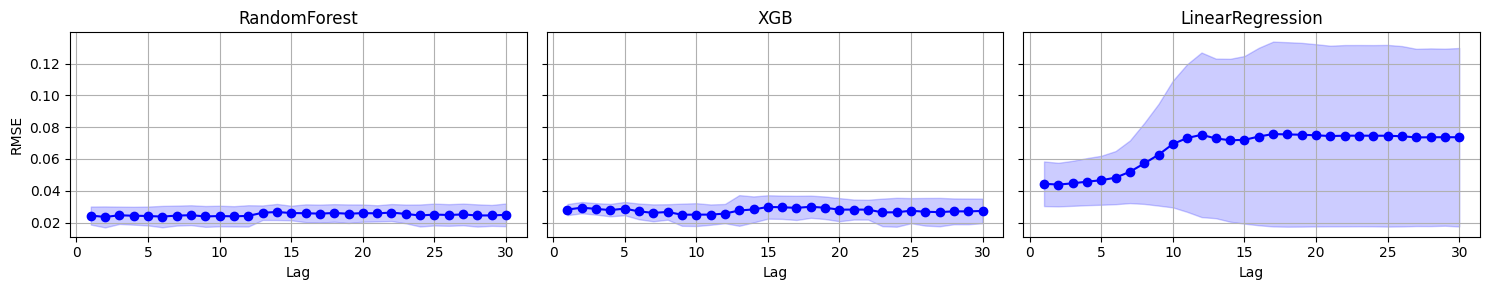

In [122]:
# multivariate manual leads regression
mv_manual_regression_results, mv_manual_regression_summary, mv_manual_regression_cv = evaluation_pipeline(
    manual_leads, test_cutoff, models, lag_values, tscv)

Evaluating model: RandomForest
Best Lag for Model RandomForest: Lag 29, Best Average RMSE (Validation): 0.02486750245143261, RMSE (Test): 0.005000658618972964
Evaluating model: XGB
Best Lag for Model XGB: Lag 27, Best Average RMSE (Validation): 0.02638576253407174, RMSE (Test): 0.026433040615553686
Evaluating model: LinearRegression
Best Lag for Model LinearRegression: Lag 22, Best Average RMSE (Validation): 0.020490861574669287, RMSE (Test): 0.005905398878848507


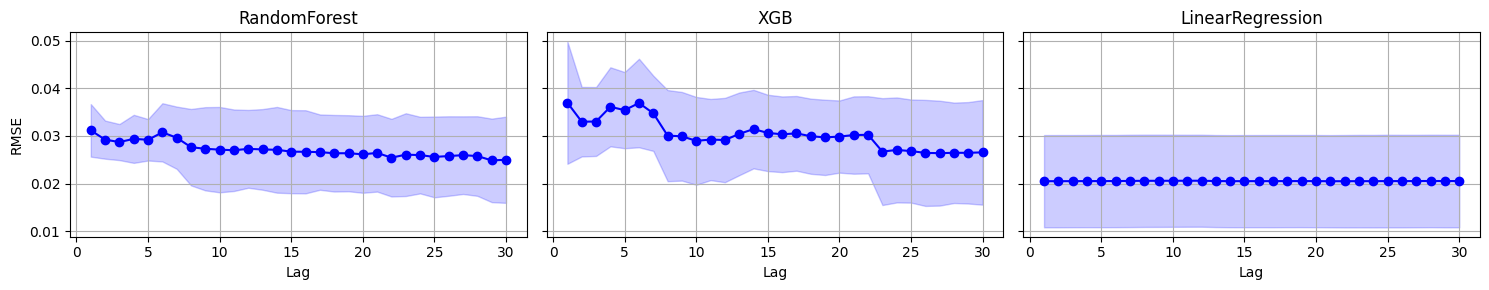

In [123]:
# univariate manual leads regression 
uv_manual_regression_results, uv_manual_regression_summary, uv_manual_regression_cv = evaluation_pipeline(
    manual_leads.iloc[:, :4], test_cutoff, models, lag_values, tscv)

Evaluating model: RandomForest
Best Lag for Model RandomForest: Lag 22, Best Average RMSE (Validation): 0.021158121444993516, RMSE (Test): 0.012738433676109126
Evaluating model: XGB
Best Lag for Model XGB: Lag 6, Best Average RMSE (Validation): 0.042841898966272024, RMSE (Test): 0.024991226460439785
Evaluating model: LinearRegression
Best Lag for Model LinearRegression: Lag 1, Best Average RMSE (Validation): 0.04929495030227623, RMSE (Test): 0.0317239785644411


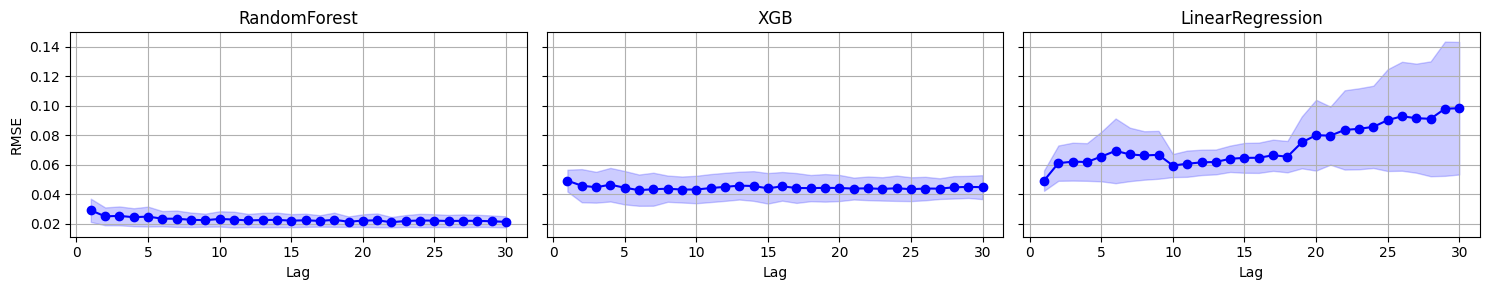

In [125]:
# multivariate website leads regression 
mv_website_regression_results, mv_website_regression_summary, mv_website_regression_cv = evaluation_pipeline(
    website_leads, test_cutoff, models, lag_values, tscv)

Evaluating model: RandomForest
Best Lag for Model RandomForest: Lag 24, Best Average RMSE (Validation): 0.016661126815262425, RMSE (Test): 0.012738791090670607
Evaluating model: XGB
Best Lag for Model XGB: Lag 11, Best Average RMSE (Validation): 0.018513222538017942, RMSE (Test): 0.011422085143605817
Evaluating model: LinearRegression
Best Lag for Model LinearRegression: Lag 1, Best Average RMSE (Validation): 0.016483428327664477, RMSE (Test): 0.01230133933511722


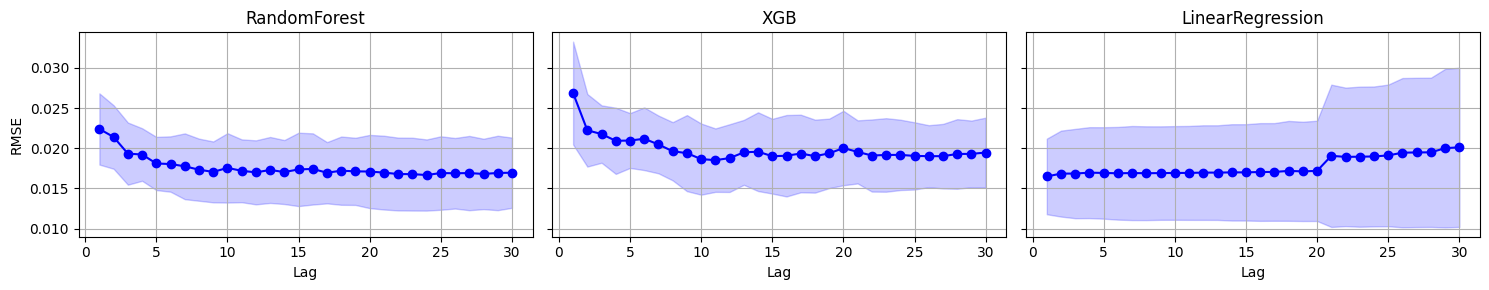

In [ ]:
# univariate website leads regression
uv_website_regression_results, uv_website_regression_summary, uv_website_regression_cv = evaluation_pipeline(
    website_leads.iloc[:, :4], test_cutoff, models, lag_values, tscv)

The strategy for which we choose the prediction model is to choose the model with the best Test-set performacne while taking into account the stability of the model during the cross-validation (see the plots above). If a model shows high volatility we choose another model of the bunch with similar performacne but lower variability.

In [126]:
def evaluate_exponential_smoothing(data, validation_cutoff, test_cutoff):
    
    data = data.reset_index(drop=True)
    
    train_series = data[data['Date'] < validation_cutoff]['NextDayLeads']
    val_series = data[(data['Date'] >= validation_cutoff) & (data['Date'] < test_cutoff)]['NextDayLeads']
    test_series = data[data['Date'] >= test_cutoff]['NextDayLeads']

    
    # Create the Exponential Smoothing model - because we see a strong pattern in days of the week, we will use a weekly seasonality
    model = ExponentialSmoothing(train_series, trend='add', seasonal='add', seasonal_periods=7)

    # Fit the model on the training data with optimized smoothing parameters
    model_fit = model.fit(optimized=True)

    # Predict using the validation data
    val_predictions = model_fit.forecast(len(val_series))
    test_predictions = model_fit.forecast(len(test_series))

    # Calculate Root Mean Squared Error for validation set
    val_rmse = np.sqrt(mean_squared_error(val_series, val_predictions))

    # Calculate Root Mean Squared Error for test set
    test_rmse = np.sqrt(mean_squared_error(test_series, test_predictions))

    return model_fit, val_rmse, test_rmse

In [127]:
def evaluate_exponential_smoothing_rolling(data, validation_cutoff, test_cutoff):
    data = data.reset_index(drop=True)
    
    val_series = data[(data['Date'] >= validation_cutoff) & (data['Date'] < test_cutoff)]['NextDayLeads']
    test_series = data[data['Date'] >= test_cutoff]['NextDayLeads']
    
    model_fit = None  # Initialize the model
    
    val_predictions = []
    test_predictions = []
    

    for i in range(len(val_series)):
        train_series = data[data['Date'] < validation_cutoff + pd.DateOffset(days=i)]['NextDayLeads']

        # Create the Exponential Smoothing model
        model = ExponentialSmoothing(train_series, trend='add', seasonal='add', seasonal_periods=7)
        
        # Fit the model on the training data
        model_fit = model.fit(optimized=True)
        
        # Predict using the validation data
        val_prediction = model_fit.forecast(1)
        val_predictions.append(val_prediction)
    
    for i in range(len(test_series)):
        train_series = data[data['Date'] < test_cutoff + pd.DateOffset(days=i)]['NextDayLeads']
        # Create the Exponential Smoothing model
        model = ExponentialSmoothing(train_series, trend='add', seasonal='add', seasonal_periods=7)
        # Train the model with validation data before predicting for the test set
        model_fit = model.fit(optimized=True)
        # Predict using the test data
        test_prediction = model_fit.forecast(1)
        test_predictions.append(test_prediction)

    return model_fit, np.sqrt(mean_squared_error(val_series, val_predictions)), np.sqrt(mean_squared_error(test_series, test_predictions))

In [128]:
print("Evaluating model: Exponential Smoothing")
es_manual, es_manual_val_rmse, es_manual_test_rmse = evaluate_exponential_smoothing(manual_leads, "2023-02-01", "2023-03-01")
print(f"RMSE (Validation): {es_manual_val_rmse}\nRMSE (Test): {es_manual_test_rmse}") 

Evaluating model: Exponential Smoothing
RMSE (Validation): 0.06912003402398106
RMSE (Test): 0.004210868501552985


In [80]:
es_manual.summary()

Dep. Variable:,NextDayLeads,No. Observations:,1033
Model:,ExponentialSmoothing,SSE,0.309
Optimized:,True,AIC,-8360.725
Trend:,Additive,BIC,-8306.383
Seasonal:,Additive,AICC,-8360.368
Seasonal Periods:,7,Date:,"Fri, 11 Aug 2023"
Box-Cox:,False,Time:,09:35:24
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0100725,alpha,True
smoothing_trend,0.000000,beta,True


In [81]:
es_fit_rolling_manual, es_fit_rolling_manual_val_rmse, es_fit_rolling_manual_test_rmse = evaluate_exponential_smoothing_rolling(manual_leads, validation_cutoff, test_cutoff)

print("Exponential Smoothing (Rolling Evaluation):")
print("RMSE (Validation):", es_fit_rolling_manual_val_rmse)
print("RMSE (Test):", es_fit_rolling_manual_test_rmse)

Exponential Smoothing (Rolling Evaluation):
RMSE (Validation): 0.06915430030845066
RMSE (Test): 0.005468402302420045


In [82]:
print("Evaluating model: Exponential Smoothing")
es_website, es_website_val_rmse, es_website_test_rmse = evaluate_exponential_smoothing(website_leads, "2023-02-01", "2023-03-01")
print(f"RMSE (Validation): {es_website_val_rmse}\nRMSE (Test): {es_website_test_rmse}") 

Evaluating model: Exponential Smoothing
RMSE (Validation): 0.016710461835884
RMSE (Test): 0.015154468926691369


In [83]:
es_website.summary()

Dep. Variable:,NextDayLeads,No. Observations:,597
Model:,ExponentialSmoothing,SSE,0.162
Optimized:,True,AIC,-4880.351
Trend:,Additive,BIC,-4832.040
Seasonal:,Additive,AICC,-4879.727
Seasonal Periods:,7,Date:,"Fri, 11 Aug 2023"
Box-Cox:,False,Time:,09:35:39
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2033348,alpha,True
smoothing_trend,0.000000,beta,True


In [84]:
es_fit_rolling_website, es_fit_rolling_website_val_rmse, es_fit_rolling_website_test_rmse = evaluate_exponential_smoothing_rolling(website_leads, validation_cutoff, test_cutoff)

print("Exponential Smoothing (Rolling Evaluation):")
print("RMSE (Validation):", es_fit_rolling_website_val_rmse)
print("RMSE (Test):", es_fit_rolling_website_test_rmse)

Exponential Smoothing (Rolling Evaluation):
RMSE (Validation): 0.016941712089323675
RMSE (Test): 0.012644348954843912


In [85]:
def evaluate_naive(data, validation_cutoff, test_cutoff):

    val_series = data[(data['Date'] >= validation_cutoff) & (data['Date'] < test_cutoff)]['NextDayLeads']
    test_series = data[data['Date'] >= test_cutoff]['NextDayLeads']

    # Predict using the last observed value for validation and test sets
    val_predictions = val_series.shift(1).fillna(method='bfill')
    test_predictions = test_series.shift(1).fillna(method='bfill')

    # Calculate Root Mean Squared Error for validation set
    val_rmse = np.sqrt(mean_squared_error(val_series, val_predictions))

    # Calculate Root Mean Squared Error for test set
    test_rmse = np.sqrt(mean_squared_error(test_series, test_predictions))

    return val_rmse, test_rmse

In [86]:
print("Evaluating model: Naive") 
naive_manual_val_rmse, naive_manual_test_rmse = evaluate_naive(manual_leads, "2023-02-01", "2023-03-01")
print(f"RMSE (Validation): {naive_manual_val_rmse}, RMSE (Test): {naive_manual_test_rmse}") 

Evaluating model: Naive
RMSE (Validation): 0.06986288314091191, RMSE (Test): 0.005618472023185589


In [87]:
print("Evaluating model: Naive") 
naive_website_val_rmse, naive_website_test_rmse = evaluate_naive(website_leads, "2023-02-01", "2023-03-01")
print(f"RMSE (Validation): {naive_manual_val_rmse}, RMSE (Test): {naive_manual_test_rmse}") 

Evaluating model: Naive
RMSE (Validation): 0.06986288314091191, RMSE (Test): 0.005618472023185589


<a id='evaluation'></a> <p style="text-decoration: underline; font-style: italic; font-size:24px">Evaluation</p>

In [107]:
website_dict = {
    "Univariate": uv_website_regression_results,
    "Multivariate": mv_website_regression_results
}

website = {main_key + sub_key: website_dict[main_key][sub_key] 
    for main_key in website_dict 
    for sub_key in website_dict[main_key]}

manual_dict = {
    "Univariate": uv_manual_regression_results,
    "Multivariate": mv_manual_regression_results
}

manual = {main_key + sub_key: manual_dict[main_key][sub_key] 
    for main_key in manual_dict 
    for sub_key in manual_dict[main_key]}

In [108]:
website['ExponentialSmoothing'] = es_website_test_rmse
website['RollingExponentialSmoothing'] = es_fit_rolling_website_test_rmse
website['Naive'] = naive_website_test_rmse

manual['ExponentialSmoothing'] = es_manual_test_rmse
manual['RollingExponentialSmoothing'] = es_fit_rolling_manual_test_rmse
manual['Naive'] = naive_manual_test_rmse

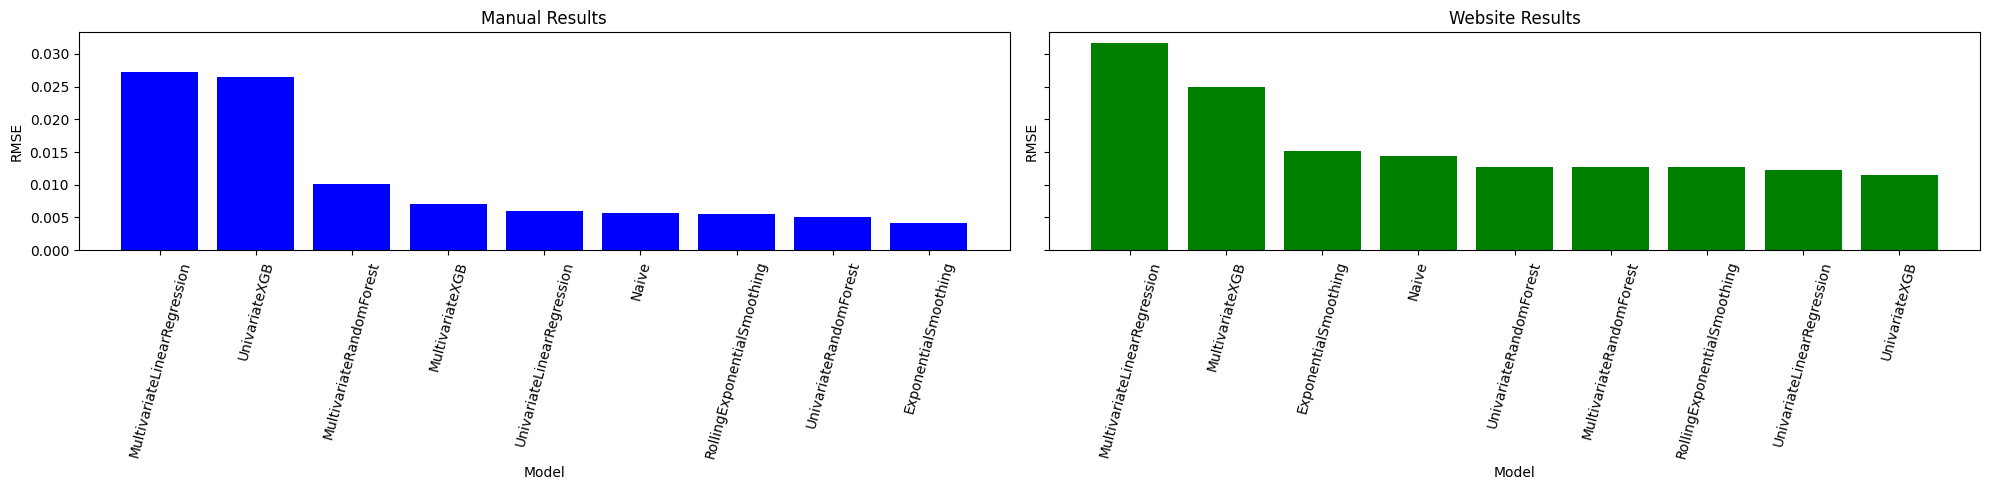

In [109]:
# Sort dictionaries by values in descending order
sorted_manual = {k: v for k, v in sorted(manual.items(), key=lambda item: item[1], reverse=True)}
sorted_website = {k: v for k, v in sorted(website.items(), key=lambda item: item[1], reverse=True)}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
axes[0].bar(list(sorted_manual.keys()), list(sorted_manual.values()), color='blue')
axes[0].set_title('Manual Results')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=75)

axes[1].bar(list(sorted_website.keys()), list(sorted_website.values()), color='green')
axes[1].set_title('Website Results')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=75)

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

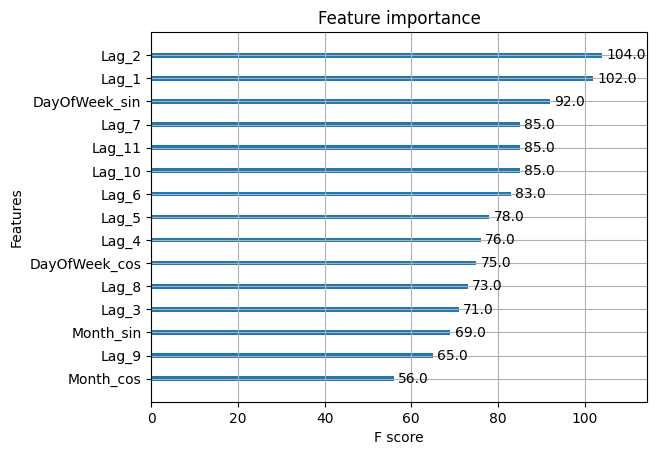

In [171]:
xgb_model = uv_website_regression_summary['XGB'][11]['Model Lag 11']

xgb.plot_importance(xgb_model)

The XGB model seems stable in the cross-validation for lag 11 and the feature importance seems quite balanced - therefore we choose it to be our final model for websites. 

For manual leads exponential smoothing seems to be a good option as we have discovered, that macro data does not hold predictive power over the leads. We found a strong structure in weekday leads therefore we find, that exponential smoothing with a weekday seasonality is a good fit and choose it for our model

**<u>The Models that we choose are:</u>**

**Exponential Smoothing Manual Leads:**
- *RMSE (Validation):* `0.06912003402398106`
- *RMSE (Test):* `0.004210868501552985`

**Univariate XGB (Lag 11) Website Leads:**
- *RMSE (Validation):* `0.018513222538017942`
- *RMSE (Test):* `0.011422085143605817`

<a id='final-predictions'></a> <p style="text-decoration: underline; font-style: italic; font-size:24px">Final Predictions April</p>

In [172]:
def transform_data(dataframes):

    dt_Leads = dataframes['Leads']
    dt_Leads.rename(columns={'DateCreated': 'Date'}, inplace=True)
    dt_Ads = dataframes['Ads']
    dt_Traffic = dataframes['WebsiteTraffic']
    dt_Macro = dataframes['Macro']

    manual_leads = dt_Leads[dt_Leads['Type'] == 'Manual'].copy()
    manual_leads = manual_leads[['Date', 'NextDayLeads']]
    
    # Pivot the dataframe to have one date per row and one-hot encoding for Platform and Funnel
    pivot_Ads = dt_Ads.pivot_table(index='Date', columns=['Platform'], values=['Spend', 'Impressions', 'Clicks'], aggfunc='sum')
    # Flatten the multi-level column index
    pivot_Ads.columns = ['_'.join(col).strip() for col in pivot_Ads.columns.values]
    # Reset index to make 'Date' a regular column
    pivot_Ads = pivot_Ads.reset_index().set_index('Date')
    dt_Ads = pd.concat([pivot_Ads.filter(like='Google Ads', axis=1), pivot_Ads.filter(like='LinkedIn Ads', axis=1)], axis=1)

    website_leads = dt_Leads[dt_Leads['Type'] == 'Website'].copy()
    website_leads = website_leads.merge(dt_Ads, how='left', on='Date')
    website_leads = website_leads.merge(dt_Traffic, how='left', on='Date')
    website_leads = website_leads.merge(dt_Macro, how='left', on='Date')
    website_leads = website_leads.query(f"Date >= '{dt_Ads.index.min()}'")
    website_leads[dt_Macro.loc[:, dt_Macro.columns != 'Date'].columns] = website_leads[dt_Macro.loc[:, dt_Macro.columns != 'Date'].columns].fillna(method='ffill')
    website_leads.fillna(0, inplace=True)
    
    return manual_leads, generate_time_series_features(website_leads.iloc[:, :3], range(1,12))

In [173]:
full_manual_leads, full_website_leads = transform_data(dataframes)

In [174]:
# creating predictions for manual leads in april 

april_manual_leads = full_manual_leads.query('Date >= "2023-04-01"').NextDayLeads
train_manual_leads = full_manual_leads.query('Date < "2023-04-01"').NextDayLeads

model = ExponentialSmoothing(train_manual_leads, trend='add', seasonal='add', seasonal_periods=7)

# Fit the model on the training data with optimized smoothing parameters
model_fit = model.fit(optimized=True)

# Predict using the validation data
predictions_manual_april = model_fit.forecast(len(april_manual_leads))

In [175]:
# creating predictions for website leads in april 

april_website_leads = full_website_leads.query('Date >= "2023-04-01"').NextDayLeads

april_website_leads_features = (full_website_leads
    .query('Date >= "2023-04-01"')
    .drop(columns=['Date', 'Type', 'NextDayLeads'])
    .sort_index(axis=1)
)

# Predict
predictions_website_april = xgb_model.predict(april_website_leads_features)

In [176]:
# Evaluation

# Concatenate actual values
combined_actual_leads = np.concatenate([april_manual_leads, april_website_leads])

# Concatenate predicted values
combined_predictions = np.concatenate([predictions_manual_april, predictions_website_april])

# Compute combined RMSE
combined_rmse = mean_squared_error(combined_actual_leads, combined_predictions, squared=False)

print("Combined RMSE: ", combined_rmse)

Combined RMSE:  0.4319209215614661
